# 学習に関するテクニック

- 重みパラメータの最適化手法
- 重みパラメータの初期値
- ハイパーパラメータ（学習率など）の設定方法
- 過学習の対応策
- Batched Normalization

## パラメータの更新

重みパラメータを勾配に従って変化させる確率的勾配降下法(SGD: stochastic gradient descent)を使ってきた。
SGDは単純な方法で、問題によってはより適した手法がある。SGDの欠点と別の最適化手法を示す。

### SGD

$$W \leftarrow W - \eta \frac{\partial L}{\partial W}$$



In [2]:
class SGD:
    def __init__(seld, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads): # params['W1'], grads['W1']
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### SGDの欠点

次の関数の最小値を求める問題を考える。

$$f(x, y) = \frac{1}{20}x^2 + y^2$$

この関数の勾配を取ると、多くの箇所で解となる $(0, 0)$ の方向を差さない特徴がある。

根本原因は勾配の方向に解がないことが挙げられる。この問題に対しよりスマートな手法を挙げる。

### Momentum

運動量(Momentum)という言葉で、物理に関係がある。

$$ v \leftarrow \alpha v - \eta \frac{\partial L}{\partial W} $$

$$ W \leftarrow W + v $$

vは物理で言うと速度で、勾配方向にボールが転がるイメージになる。$\alpha$は空気抵抗や摩擦など物体を徐々に止めるもの。

In [4]:
import numpy as np

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

### AdaGrad

学習率が大きすぎると発散し、小さすぎると時間がかかりすぎる問題がある。
これに対する有効なテクニックとして、学習係数の減衰(learning rate decay)という方法があり、ニューラルネットワークの学習ではよく使われる。

パラメータ全体の学習係数を一括して下げることを発展させ一つ一つのパラメータを対象とするのがAdaGrad。
パラメータの要素ごとに適応的に学習係数を調整する。

$$ h \leftarrow h + \frac{\partial L}{\partial W} \circ \frac{\partial L}{\partial W} $$

$$ W \leftarrow W - \eta \frac{1}{\sqrt{h}} \frac{\partial L}{\partial W} $$

hはこれまで経験した勾配の値の2乗和を保持する。($\circ$は行列の要素ごとの掛け算）

更新の際に$1/\sqrt{h}$を乗算し学習のスケールを調整する。これで大きく更新された学習係数が次第に小さくなる。

> AdaGradは更新量が0になっていく問題があり、これを改善したRMSPropという方法がある。

In [5]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### Adam

MomentumとAdaGradをあわせたような手法としてAdamがある。

多くの研究では今でもSGDが使われている。問題によって適した手法がある。

In [6]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

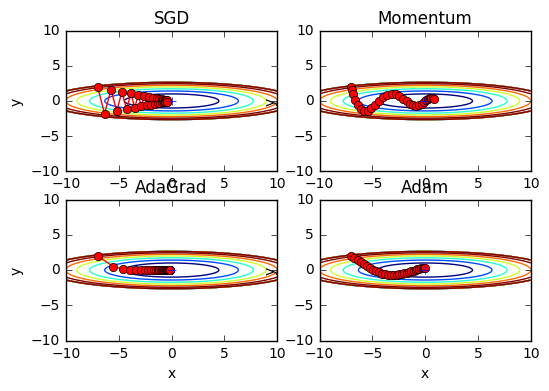

In [7]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

### MNISTデータセットによる更新手法の比較

5層のニューラルネットワークで各層のニューロンは100個、活性化関数はReLUで実験すると、SGDより他の3つがだいたい同じ感じで学習が進むようにみえる。
ただし学習係数のハイパーパラメータやニューラルネットワークの構造などによって結果は変化するため注意が必要だが、一般にSGDよりも他の3つの方法が早く学習でき最終的な認識性能も高くなる。

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
===========iteration:0===========
AdaGrad:2.26431943
SGD:2.40171244042
Momentum:2.41763390215
Adam:2.20911382966
===========iteration:100===========
AdaGrad:0.16020221766
SGD:1.65287245646
Momentum:0.358627573178
Adam:0.229356965133
===========iteration:200===========
AdaGrad:0.131910672027
SGD:0.875211105093
Momentum:0.302785023753
Adam:0.237668949975
===========iteration:300===========
AdaGrad:0.0519214015894
SGD:0.49133067024
Momentum:0.173131978533
Adam:0.118850983415
===========iteration:400===========
AdaGrad:0.0434717760731
SGD:0.508019044042
Momentum:0.179687433278
Adam:0.152625986004
===========iteration:500===========
AdaGrad:0.0659907538603
SGD:0.334068836264
Momentum:0.131653571382
Adam:0.11644455624
=

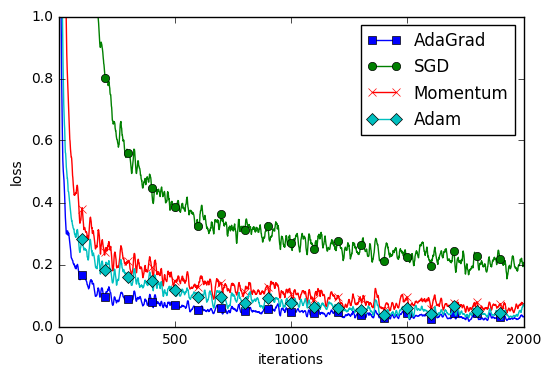

In [8]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()